In [3]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import sys, os
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from tqdm import tqdm
import matplotlib as mpl
mpl.style.use('pof')

import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        obj = pickle.load(input)
    return obj

In [4]:
"""This needs its seperated notebook because the later dump files were accidentally deleted,
and only the eta and field files are redtored."""

'This needs its seperated notebook because the later dump files were accidentally deleted,\nand only the eta and field files are redtored.'

In [5]:
"""Compute the Reynolds stress"""

def field (case, time, PRE=False, PLOT=False):
    """Put the field slices together and compute some turbulent statistics.
    Pickle the fileds if it's the first time read-in.
    
    Args:
    case: the case instance providing metadata
    time: the times where we want to compute the field statistics
    
    Returns:
    Write the following fields as case attributes.
    
    TODO: add coordinate transformation.
    
    """
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    working_dir = case.path
    case.tstat = time # time that the statistics are computed
    case.eta =[]; case.eta_shift = [] # 1D eta (shift or not)
    case.ux = []; case.uy = []; case.f = [] # 2D ux uy # 2D ux uy
    case.re_stress = []
    """Instead of recording shifted fields, record shifting index
    Then do field_shift = np.roll(field, -idx) in x direction when needed."""
    case.shift_index = []
    case.ux_shift = []; case.uy_shift = []; case.f_shift = [] # 2D ux uy shifted, leave blank
    case.re_stress_shift = [] # 2D re shifted
    case.uxmean = [] # 1D ux mean
    case.ux_center = []; case.uy_center = []; case.f_center = [] # The center non-averaged slice to show turbulence
    case.ux_yzcrest = []; case.uy_yzcrest = []; case.f_yzcrest = [] # The y-z plane slice at crest x
    case.ux_yztrough = []; case.uy_yztrough = []; case.f_yztrough = [] # The y-z plane slice at trough x
    
    for t in tqdm(time):
        # Read in eta (not utilize the Interface class)
        filename = working_dir + 'eta/eta_t%g' % 59
        snapshot = pd.read_table(filename, delimiter = ',')
        eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
        xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2 
        zarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
        x_tile, z_tile = np.meshgrid(xarray,zarray)
        eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                                 (x_tile, z_tile), method='nearest')
        eta_1D = np.average(eta_tile, axis=0)
        # Read in eta (utilize the Interface class)
        """For precursor cases just read the fixed shape"""
        """For moving wave cases just read the fixed shape"""
#         if (PRE == True): 
#             interface = Interface2D(L0 = 2*np.pi, N = 512, path = case.path, 
#                                     pre='eta/eta_pre', t = None, PRUNING=True)
#             eta_1D = np.average(interface.eta, axis=0)        
#         else: 
#             interface = Interface2D(L0 = 2*np.pi, N = 512, path = case.path, 
#                                     pre='eta/eta_loc_t', t = t, PRUNING=True)
#             eta_1D = np.average(interface.eta, axis=0)
        # Filter the data (subtract the mean)
        eta_1D_filtered = butter_lowpass_filter(eta_1D-np.average(eta_1D))
        analytic_signal = hilbert(eta_1D_filtered)
        phase = np.angle(analytic_signal)
        # Shift the velocity field along x axis so that phase starts at 0
        idx = (np.abs(phase - 0)).argmin()
#         eta_1D_shift = np.roll(eta_1D, -idx)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        f_3D = {'name':'f', 'value':[]}

        # Read in the fields either from pickle or from slice data
        for field in (ux_3D,uy_3D,f_3D):           
            picklename = working_dir + 'field/'+field['name']+'_t%g' % t +'.pkl'
            exists = os.path.exists(picklename)
            # If the pickle is there read in the pickles
            if exists:
                field['value'] = load_object(picklename)
                print('pickle restored!')
            # If no pickle read in from the slice files and pickle dump
            if not exists:
                for sn in range (0, NSLICE-1):
                    filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
                    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                    snapshot.reshape([NGRID,NGRID+1])
                    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
                field['value'] = np.array(field['value'])
                save_object(field['value'], picklename)
                
        # Compute Reynolds stress (not shifted)
        ux_mean = np.tile(np.average(ux_3D['value'], axis=(0,1)), (ux_3D['value'].shape[1], 1)) 
        uy_mean = np.tile(np.average(uy_3D['value'], axis=(0,1)), (uy_3D['value'].shape[1], 1))
        re_stress_3D = (ux_3D['value']-ux_mean)*(uy_3D['value']-uy_mean)
        # Append z direction averaged 2D profile
        case.eta.append(eta_1D)
        case.ux.append(np.average(ux_3D['value'], axis=0))
        case.uy.append(np.average(uy_3D['value'], axis=0))
        case.f.append(np.average(f_3D['value'], axis=0))
        # A few fields for visualization
        # First is the center field
        SAMPLE = np.int(ux_3D['value'].shape[0]/2)
        print(SAMPLE) # center in z
        case.ux_center.append(ux_3D['value'][SAMPLE].copy())
        case.uy_center.append(uy_3D['value'][SAMPLE].copy())
        case.f_center.append(f_3D['value'][SAMPLE].copy())        
        # Second is at crest and trough (require shifted field)
        # These are only for plotting
        if PLOT == True:
            ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
            uy_3D_shift = {'name':'uy_shift', 'value':[]}
            f_3D_shift = {'name':'f_shift', 'value':[]}
            for (field,field_shift) in zip((ux_3D,uy_3D,f_3D),(ux_3D_shift,uy_3D_shift,f_3D_shift)):
                field_shift['value'] = np.roll(field['value'], -idx, axis=1)
            case.ux_yzcrest.append(ux_3D_shift['value'][:,256,:].copy()) # z, x, y
            case.uy_yzcrest.append(uy_3D_shift['value'][:,256,:].copy())
            case.f_yzcrest.append(f_3D_shift['value'][:,256,:].copy())
            case.ux_yztrough.append(ux_3D_shift['value'][:,192,:].copy()) # z, x, y
            case.uy_yztrough.append(uy_3D_shift['value'][:,192,:].copy())
            case.f_yztrough.append(f_3D_shift['value'][:,192,:].copy())
        case.shift_index.append(idx)
        case.re_stress.append(np.average(re_stress_3D, axis=0))        
        # Additional 1D profile
        case.uxmean.append(np.average(ux_3D['value'], axis=(0,1)))
        case.yarray = np.linspace(0,case.L0,case.N,endpoint=False)+case.L0/2**case.N/2 # Centered grid for interpolation
        del(ux_3D, uy_3D, f_3D, ux_mean, uy_mean, re_stress_3D)
        gc.collect()
        
# Pick a case, and time range
# time1 = np.arange(50,59,1.)
# time2 = np.arange(59.5,61,0.5)
# time = np.concatenate((time1,time2), axis=None)

In [6]:
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/project_specific/windwave/')
from helper import RealWave

class Case():
    """
        Class for each case. Initialization takes in the metadata like Bo, Re, ak etc.
        self.availt: The longest running time
        self.path: Path of the case file
    """
    def __init__(self, ustar, Retau, Bo, g, ak, LEVEL, emax, alterMU=1., L0=2*np.pi, k=4., h=1., OUTLEVEL=8,
                 working_dir='/home/jiarong/research/projects/turbulence/', prefix='curved_fixREtau_', 
                 PRINTWAVE=False, NOMATCH=True, PRECURSOR=False):
        '''
        alterMU: the altered MU ratio. Default 1. Turn on NOMATCH as well.
        self.N: output grid number
        '''
        # Register the metadata and spell the path
        if PRECURSOR:
            self.ustar = ustar; self.ak = ak; self.Bo = None; self.Retau = Retau; self.alterMU = None
            self.emax=0.3; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = None; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = None
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            self.path = working_dir + prefix + 'REtau%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.ak,self.LEVEL,self.emax) 
        else:   
            self.ustar = ustar; self.ak = ak; self.Bo = Bo; self.Retau = Retau; self.alterMU = alterMU
            self.emax=0.3; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = g; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = self.g/(self.Bo*self.k**2)
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            if NOMATCH == True:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_MU%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.alterMU,self.LEVEL,self.emax) 
            else:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.LEVEL,self.emax) 
            # Run wave helper function to compute wave related info0
            # Notice that this depends on the definition of the wave in the specific set of cases
            self.wave = RealWave(g=self.g, sigma=self.sigma, rho=self.rho1, rho_air=self.rho2, mu = self.mu1, mu_air = self.mu2)
            self.wave.k2omega(self.k)       
            # Print out wave info; to double check, print the message file
            if PRINTWAVE:
                print(self.path)
                print("mu1 = %g, rho1 = %g, mu2 = %g, rho2 = %g, sigma = %g" %(self.mu1, self.rho1, self.mu2, self.rho2, self.sigma))
                print("Given k = %g (1/m), calculated omega = %g (1/s), period = %g (s), phase speed c = %g (m/s), wavelength = %g (m), Bo = %g" 
                      %(self.wave.k, self.wave.omega, 2*np.pi/self.wave.omega, self.wave.c, self.wave.wl, self.Bo))
                f = open(self.path+"message", "r")
                print(f.read())

In [7]:
case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_restore_')

/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_restore_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/
mu1 = 7.67063e-06, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.0003125
Given k = 4 (1/m), calculated omega = 2.00499 (1/s), period = 3.13377 (s), phase speed c = 0.501248 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 1, c = 0.501248, Ustar = 0.25, MURATIO = 0.01831, mu_w = 7.67063e-06, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.0003125, Bo = 200, RE = 102646, Re_tau = 720
RELEASETIME = 57, uemax = 0.075 
slurmstepd: error: *** STEP 6249387.0 ON tiger-h24c2n7 CANCELLED AT 2021-04-18T06:03:50 DUE TO TIME LIMIT ***
srun: Job step aborted: Waiting up to 47 seconds for job step to finish.



In [23]:
# Pick a case, and time range
time = [69, 84, 99, 112]
field (case, time)
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-12-d6ac7688bb3f>:92: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
<ipython-input-12-d6ac7688bb3f>:94: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  field['value'].append(snapshot[:,0:NGRID].astype(np.float))
100%|██████████| 1/1 [02

26

Text(0.5, 1.05, '$\\overline{v}/u_{*}$')

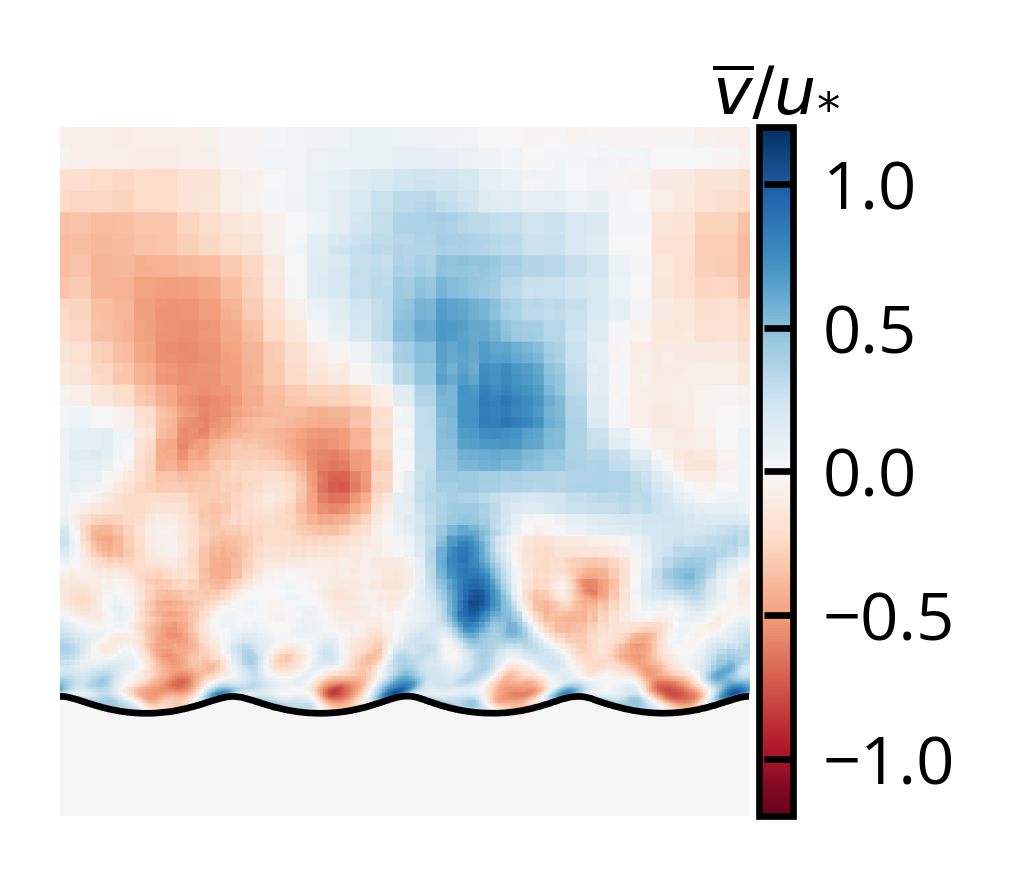

In [22]:
"""Visulization of uy"""
fig = plt.figure(figsize=[2,1.5])
ax = plt.gca()
# case.eta_shift.append(np.roll(case.eta[0], -case.shift_index[0]))
# case.uy_shift.append(np.roll(case.uy[0], -case.shift_index[0], axis=0))
# case.f_shift.append(np.roll(case.f[0], -case.shift_index[0], axis=0))
# img = plt.imshow(np.rot90(case.uy_shift[0]*(1-case.f_shift[0])/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 1.2, vmin = -1.2)
img = plt.imshow(np.rot90(case.uy_center[0]*(1-case.f_center[0])/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
                 vmax = 2, vmin = -2)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
plt.plot(xarray, case.eta_shift[0], c='k', lw=0.8)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
plt.axis('off')
cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
             transform=cbar.ax.transAxes)
# fig.savefig('/home/jiarong/Downloads/ICTAM/uy_g1.pdf')

(-3.141592653589793, 3.141592653589793, 0.0, 6.283185307179586)

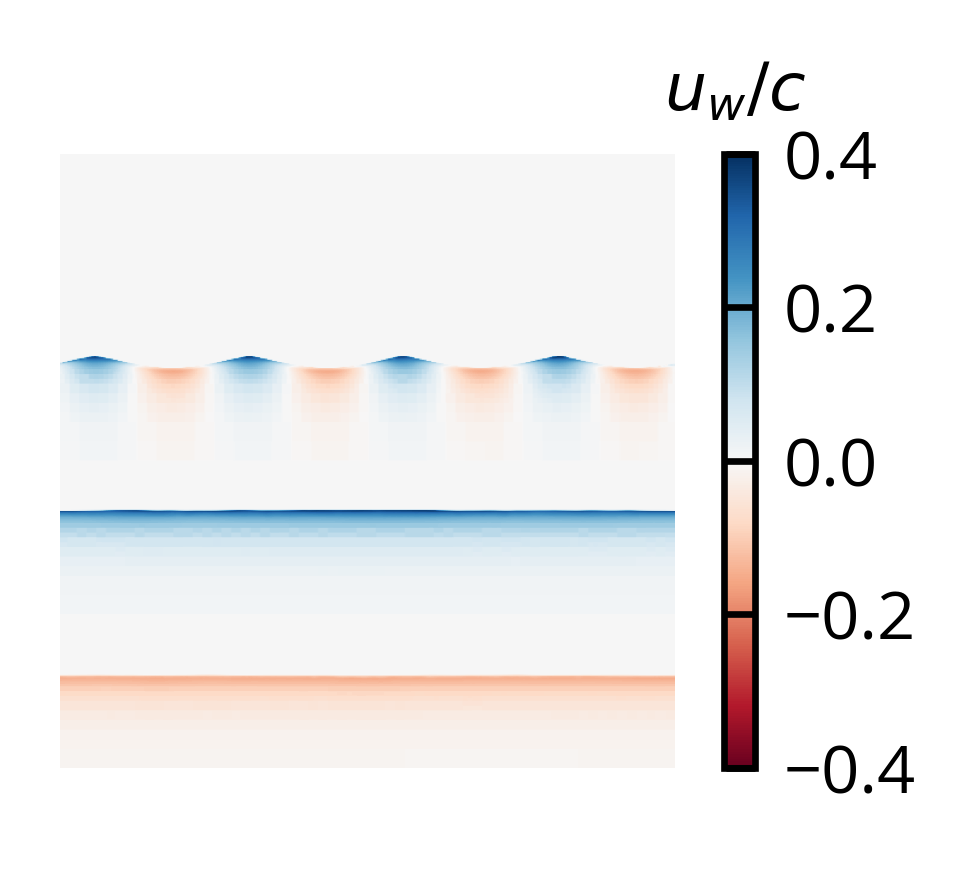

In [24]:
fig = plt.figure (figsize = [2,1.5])

"""Put the x-y and x-z plane together"""
# plt.imshow(np.rot90(case.ux[0][:,0:128]*(case.f[0][:,0:128]**2)/case.wave.c), cmap='RdBu', 
#            vmax = 0.4, vmin = -0.4, extent=[-np.pi,np.pi,0,0.5*np.pi])
part1 = case.ux_center[0][1:-1:2,0:256]*(case.f_center[0][1:-1:2,0:256]**2)
part2 = case.ux_yzcrest[0][:,0:128]*(case.f_yzcrest[0][:,0:128]**2)
part3 = case.ux_yztrough[0][:,0:128]*(case.f_yztrough[0][:,0:128]**2)
img = np.concatenate((part3, part2, part1), axis=1)
plt.imshow(np.rot90(img)/case.wave.c, cmap='RdBu', 
           vmax = 0.4, vmin = -0.4, extent=[-np.pi,np.pi,0,2*np.pi])

# plt.plot(xarray, case.eta[0], c='k', lw=1)
ax = plt.gca(); ax.text(1.1,1.1, r'$u_w/c$', ha='center', va='center', transform=ax.transAxes)
plt.colorbar(); ax.axis('off')

<ipython-input-82-665b4a018777>:25: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cbar = grid.cbar_axes[0].colorbar(pcontour)
<ipython-input-82-665b4a018777>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/home/jiarong/Downloads/ICTAM/panel_uwater.pdf')
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


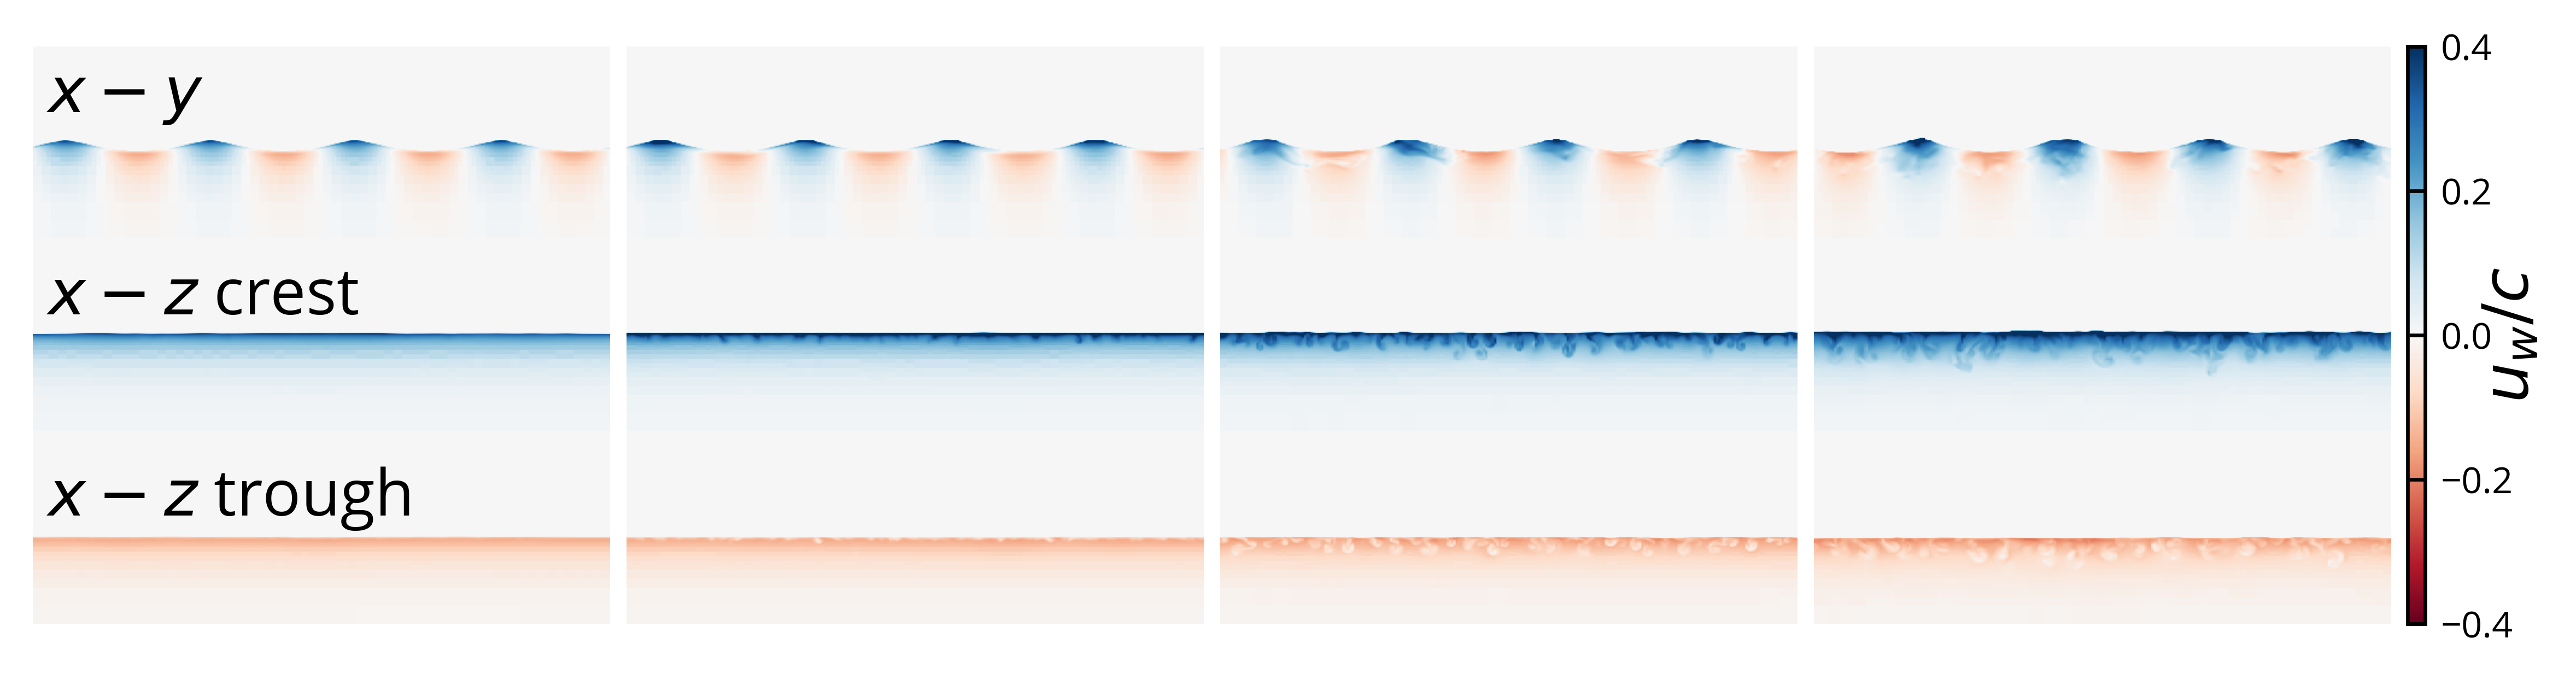

In [82]:
"""Panel of u water"""
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,2))
# ax = plt.gca()
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
for i in range(0,4):
    part1 = case.ux_center[i][1:-1:2,0:170]*(case.f_center[i][1:-1:2,0:170]**2)
    part2 = case.ux_yzcrest[i][:,0:171]*(case.f_yzcrest[i][:,0:171]**2)
    part3 = case.ux_yztrough[i][:,0:171]*(case.f_yztrough[i][:,0:171]**2)
    img = np.concatenate((part3, part2, part1), axis=1)
    pcontour = grid[i].imshow(np.rot90(img)/case.wave.c, cmap='RdBu', 
                   vmax = 0.4, vmin = -0.4, extent=[-np.pi,np.pi,0,2*np.pi])
    grid[i].axis('off')  
grid[0].text(-3, 5.4, '$x-y$ ', ha='left', va='bottom', fontsize=14)
grid[0].text(-3, 3.2, '$x-z$ crest', ha='left', va='bottom', fontsize=14)
grid[0].text(-3, 1, '$x-z$ trough', ha='left', va='bottom', fontsize=14)
cbar = grid.cbar_axes[0].colorbar(pcontour)
cbar.ax.text(7, 0, r'$u_w/c$', rotation = 90, ha='center', va='center', fontsize=14)   
fig.savefig('/home/jiarong/Downloads/ICTAM/panel_uwater.pdf')

In [7]:
time = [10,11,12,13]
fig = plt.figure(figsize=(10,2))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
for i in range(0,4):
    pcontour = grid[i].imshow(np.rot90(case.uy_center[i]*(1-case.f_center[i])/0.25), cmap='RdBu', 
                          extent=[-np.pi,np.pi,0,2*np.pi],
                          vmax = 4, vmin = -4)
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
    grid[i].plot(xarray, case.eta[i], c='k', lw=1)
    grid[i].axis('off') 
    grid[i].set_title(r"$t = %.1f T$" %((time[i]-57)/(2*np.pi/case.wave.omega)), fontsize=14)
cbar = grid.cbar_axes[0].colorbar(pcontour)
cbar.ax.text(7, 0, r'$v_a/u_{*}$', rotation = 90, ha='center', va='center', fontsize=14)     

# fig.savefig('/home/jiarong/Downloads/ICTAM/panel_vair.pdf')

# img = plt.imshow(np.rot90(case.uy_center[0]*(1-case.f_center[0])/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi],
#                  vmax = 2, vmin = -2)
# NGRID = 512; NSLICE = 256; L0 = 2*np.pi
# xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
# plt.plot(xarray, case.eta_shift[0], c='k', lw=0.8)
# cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
# plt.axis('off')
# cbar.ax.text(0.5, 1.05, r'$\overline{v}/u_{*}$', ha='center', va='center', 
#              transform=cbar.ax.transAxes)

NameError: name 'ImageGrid' is not defined

<Figure size 6000x1200 with 0 Axes>

<ipython-input-18-697b61a9d8fd>:22: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cbar = grid.cbar_axes[0].colorbar(pcontour)
<ipython-input-18-697b61a9d8fd>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('/home/jiarong/Downloads/ICTAM/panel_restress.pdf')
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


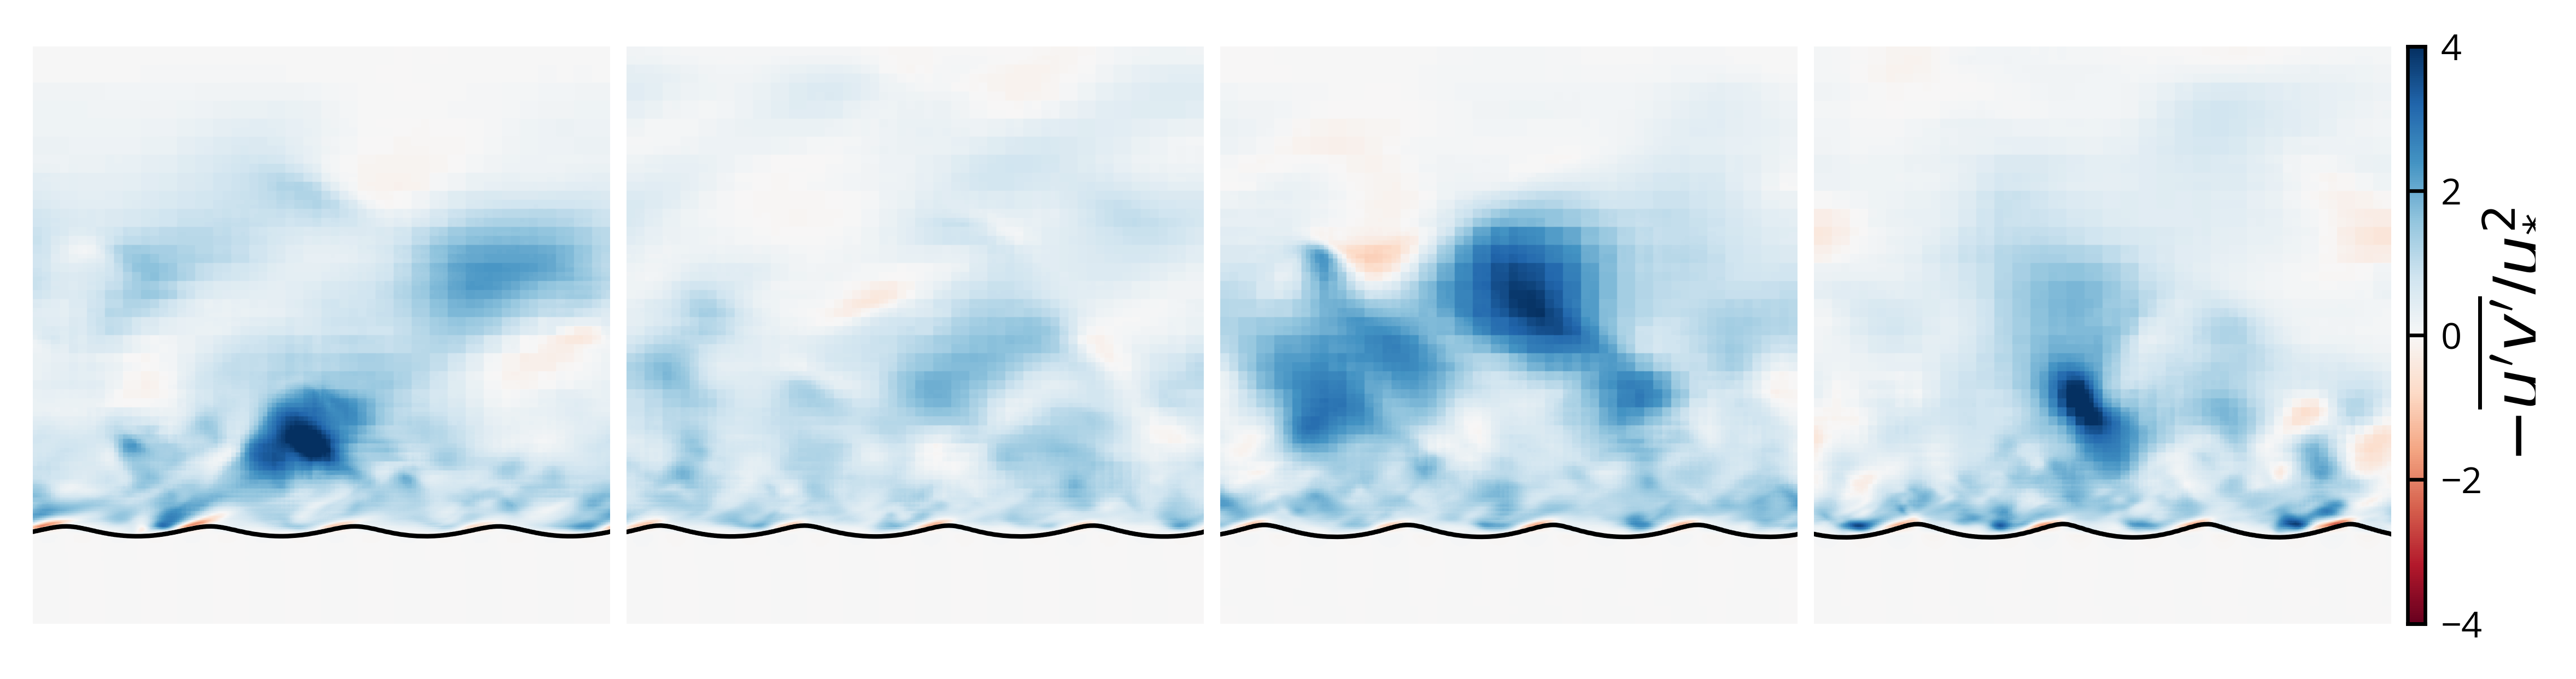

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
time = [69, 84, 99, 112]
fig = plt.figure(figsize=(10,2))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.05,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.05,
                 )
for i in range(0,4):
    pcontour = grid[i].imshow(np.rot90(-case.re_stress[i]/0.25**2), cmap='RdBu', 
                          extent=[-np.pi,np.pi,0,2*np.pi],
                          vmax = 4, vmin = -4)
    NGRID = 512; NSLICE = 256; L0 = 2*np.pi
    xarray = np.linspace(-L0/2.,L0/2.,NGRID,endpoint=False)+L0/2**NGRID/2
    grid[i].plot(xarray, case.eta[i], c='k', lw=1)
    grid[i].axis('off') 
#     grid[i].set_title(r"$t = %.1f T$" %((time[i]-57)/(2*np.pi/case.wave.omega)), fontsize=14)
cbar = grid.cbar_axes[0].colorbar(pcontour)
cbar.ax.text(7, 0, r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^2$', rotation = 90, ha='center', va='center', fontsize=14)     

fig.savefig('/home/jiarong/Downloads/ICTAM/panel_restress.pdf')

In [ ]:
"""Underwater velocity"""

In [10]:
time = [69, 84, 99, 112]
field (case, time)
gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

pickle restored!
pickle restored!
pickle restored!


 25%|██▌       | 1/4 [00:05<00:15,  5.12s/it]

pickle restored!
pickle restored!
pickle restored!


 50%|█████     | 2/4 [00:12<00:13,  6.73s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


pickle restored!
pickle restored!
pickle restored!


 75%|███████▌  | 3/4 [00:21<00:07,  7.46s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


pickle restored!
pickle restored!
pickle restored!


100%|██████████| 4/4 [00:29<00:00,  7.35s/it]


26

In [11]:
gc.collect()

15